# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Datos

In [ ]:
# Cargar dataframe
df_original = pd.read_csv('./data/raw/age_gender.csv')

In [ ]:
df = df_original.copy()
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(" "), dtype=np.float32).reshape(48, 48, 1))

In [ ]:
df["pixels"][0].shape

(48, 48, 1)

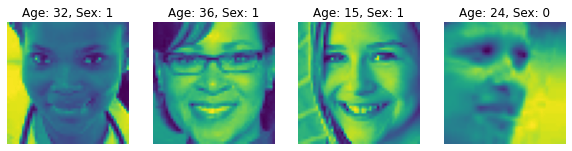

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    random_face = np.random.choice(len(df))
    axes[i].set_title('Age: {0}, Sex: {1}'.format(df['age'][random_face], df['gender'][random_face]  ))
    axes[i].imshow(df['pixels'][random_face])
    axes[i].axis('off')

### Extraer solo datos necesarios

In [ ]:
images = np.array(df["pixels"].to_list())
genders = np.array(df["gender"].to_list())

In [ ]:
print("Shape of images: {}, Shape of genders: {}".format(images.shape, genders.shape))

Shape of images: (23705, 48, 48, 1), Shape of genders: (23705,)


# Preparación Red Neuronal

In [ ]:
from sklearn.model_selection import train_test_split
images_train, image_test, genders_train, genders_test = train_test_split(images, genders, test_size=0.3, random_state=44)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

train_datagenerator = ImageDataGenerator(rescale=1/255)
train_generator = train_datagenerator.flow(
    images_train, genders_train, batch_size=32
)

test_datagenerator = ImageDataGenerator(rescale=1/255)
test_generator = test_datagenerator.flow(
    image_test, genders_test, batch_size=32
)

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=3)
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience= 2,
    verbose=1,
)

callbacks = [earlystop, learning_rate_reduction]

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout

inputs = Input(shape=(48, 48, 1))

x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='relu')(x)

model:Model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

In [ ]:
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["accuracy"])
model.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
    callbacks= callbacks
)

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot(title='Model')

In [ ]:
accurracies = pd.DataFrame(model.history.history)
accurracies[['accuracy','val_accuracy']].plot(title='Model')

# Por etnia

In [ ]:
X = df["ethnicity"]
y = df["gender"]
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X, y, test_size=0.3, random_state=44)

In [ ]:
#train_generator_ethnicity = train_datagenerator.flow(
#    X_train_ethnicity ,y_train_ethnicity ,batch_size=64
#)
#
#test_generator_ethnicity = test_datagenerator.flow(
#    X_test_ethnicity ,y_test_ethnicity ,batch_size=64
#)

In [ ]:
df["ethnicity"].value_counts()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
import tensorflow_datasets as tfds

model_ethnicity = Sequential()

# import tensorflow_datasets as tfds
dataset, info = tfds.load('iris', with_info=True)

model_ethnicity.add(Dense(units = 32, input_shape = [1]))
model_ethnicity.add(Dense(units = 64, activation = 'relu', use_bias = False))
model_ethnicity.add(Dense(units = 32, input_shape = [16]))
model_ethnicity.add(Dense(units = 64, activation = 'relu', use_bias = False))
model_ethnicity.add(Dense(units = 128, activation = 'relu', use_bias = False))
model_ethnicity.add(Dense(units = 64, activation = 'relu', use_bias = False))
model_ethnicity.add(Dense(units = 32, activation = 'relu'))
model_ethnicity.add(Dense(units = 16, activation = 'relu'))
model_ethnicity.add(Dense(units = 8, activation = 'relu', use_bias = False))
model_ethnicity.add(Dense(units = 10, activation = 'sigmoid'))

model_ethnicity.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model_ethnicity.summary()

In [ ]:
model_ethnicity.fit(
    X_train_ethnicity,
    y_train_ethnicity,
    epochs= 5,
    validation_data= (X_test_ethnicity, y_test_ethnicity)
    #callbacks= callbacks
)

In [ ]:
losses_ethnicity = pd.DataFrame(model_ethnicity.history.history)
losses_ethnicity[['accuracy','val_accuracy']].plot(title='Ethnicity')
losses_ethnicity[['loss','val_loss']].plot(title='Ethnicity')